In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Import Image manipulation
from PIL import Image

# Import data visualization
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib

# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

## imgaug

In [0]:
#! pip install --upgrade imgaug

In [0]:
# import the library and helpers --- PASSO 1
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

In [0]:
# import bounding boxes from imgaug --- PASSO 2
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [0]:
# --- PASSO 3
from PIL import Image
# --------------------- Apre filedaanalizzare.txt che contiene i nomi dei file che appartengono al dataset senza data augmentation
f = open('/content/drive/My Drive/DataAugm/filedaanalizzare.txt', "r")
nomi = []
# --------------------- Prende i nomi dei file contenuti nel filedaanalizzare.txt e li salva in set
for x in f:
  #print(x.split(',')[0])
  nomi.append(x.split(',')[0])
nomi = list(dict.fromkeys(nomi)) # toglie i duplicati
f.close()

In [0]:
# --------------------- Coverte le immagini da png a jpg e le salva in una nuova cartella DA FARE SOLO UNA VOLTA

for nome in nomi:
  nomeInpng = nome.replace('jpg', 'png')
  image = Image.open("/content/drive/My Drive/DatasetProgettoDDM/opendataset/train/"+ nomeInpng)
  image_rgb = image.convert('RGB')
  image_rgb.save('/content/drive/My Drive/dataset_random_remove/dataset/'+ nome)

# DATASET_TO_AUGMENT CONTIENE LE IMMAGINI DEL DATASET ORIGINALE MA IN FORMATO JPG

In [0]:
# --- PASSO 4
import numpy as np
from PIL import Image
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

for nome in nomi: # Per ogni nome dell'immagine da analizzare
  image = imageio.imread('/content/drive/My Drive/DataAugm/Dataset_to_augment/'+ nome)
  
  f = open('/content/drive/My Drive/DataAugm/filedaanalizzare.txt', "r")
  bb_list = []
  for line in f:
    if(line.split(',')[0] == nome):
      # Prende tutti i bounding box di immagine aperta sopra (image = imageio.imread('/content/drive/My Drive/DataAugm/Dataset_to_augment/'+ nome)) e li mette in una lista
      bb_list.append(BoundingBox(x1=int(line.split(',')[1]), x2=int(line.split(',')[3]), y1=int(line.split(',')[2]), y2=int(line.split(',')[4]), label=line.split(',')[5]))
  bbs = BoundingBoxesOnImage(bb_list, shape=image.shape) #tutti i bb della immagine aperta sopra
  f.close()

  # define a simple augmentations pipeline for the image aperta sopra with bounding box
  
  '''
  seq = iaa.Sequential([
    iaa.GammaContrast(1.5), # add contrast
    iaa.Affine(translate_percent={"x": 0.1}, scale=0.8), # Apply affine transformations to each image: translate the image.
    iaa.Fliplr(p = 1.0) # apply horizontal flip
  ])
  seq = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45)),
    iaa.GammaContrast(1.5), # add contrast
    iaa.Affine(translate_percent={"x": 0.1}, scale=0.8), # translate the image
    iaa.Fliplr(p = 1.0) # apply horizontal flip
  ])
  '''
  # Define our sequence of augmentation steps that will be applied to every image.
  seq = iaa.Sequential([  # Apply the following augmenters to most images.
          iaa.Fliplr(0.5), # horizontally flip 50% of all images
          iaa.Flipud(0.2), # vertically flip 20% of all images

          # crop some of the images by 0-10% of their height/width
          iaa.Crop(percent=(0, 0.1)),

          # Apply affine transformations to some of the images
          # - scale to 80-120% of image height/width (each axis independently)
          # - translate by -20 to +20 relative to height/width (per axis)
          # - rotate by -45 to +45 degrees
          iaa.Affine(rotate=(-45, 45)),
          iaa.Affine(translate_percent={"x": 0.1}, scale=0.8)
        ], 
        # do all of the above augmentations in random order
        random_order=True
  )
  # apply augmentations
  image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

  # Salva i BB in augmented_random.txt con ogni riga definita con questa struttura NAME_FILE, X1, Y1, X2, Y2, LABEL
  L = []
  for i in range(len(bbs_aug.bounding_boxes)):
    augm = bbs_aug.bounding_boxes[i]
    print(nome.replace('.', '_aug.') + ','+ str(int(augm.x1))+','+ str(int(augm.y1))+','+ str(int(augm.x2))+','+ str(int(augm.y2))+','+ augm.label)
    L.append(nome.replace('.', '_aug.') + ','+ str(int(augm.x1))+','+ str(int(augm.y1))+','+ str(int(augm.x2))+','+ str(int(augm.y2))+','+ augm.label)
  
  with open('/content/drive/My Drive/DataAugm/augmented_random.txt', "a") as file:
    file.writelines(L)
  file.close()
  
  # ------------------------ Saving a Numpy array as an image, in particolare, salva l'immagine augmented in una cartella
  #data = image_aug  # Non togliere il commento
  #Rescale to 0-255 and convert to uint8  # Non togliere il commento
  #rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8) # Non togliere il commento
  
  im = Image.fromarray(image_aug)
  im.save('/content/drive/My Drive/DataAugm/Dataset_augm_random/'+ nome.replace('.', '_aug.'))
  
  #FINE. CON QUESTE CASELLE AUMENTO LE IMMAGINI DEL DATASET ORIGINALE, SALVO LE NUOVE IMMAGINI AUMENTATE E I NUOVI BB

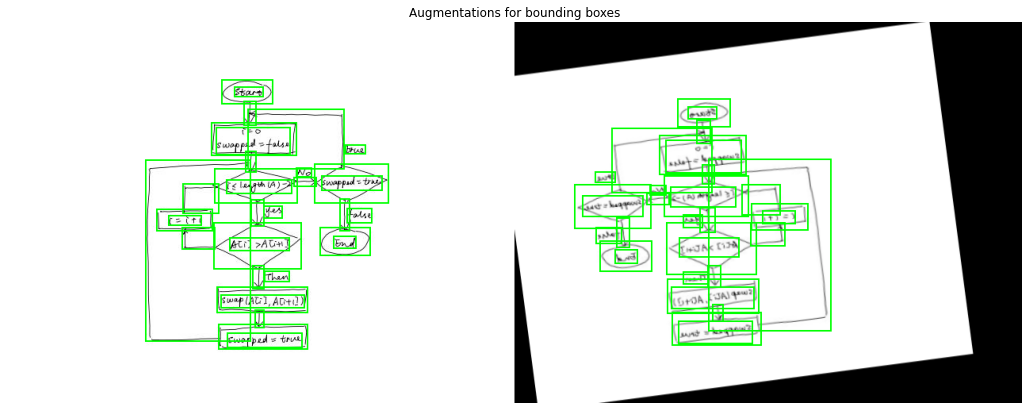

In [0]:
# plot the initial and the augmented images with bounding boxes
  # using helpers from imgaug package
  side_by_side = np.hstack([
      bbs.draw_on_image(image, size=2),
      bbs_aug.draw_on_image(image_aug, size=2)
  ])
  #print('shape',image_aug.shape)
  fig, ax = plt.subplots(figsize=(60, 7))
  ax.axis('off')
  plt.title('Augmentations for bounding boxes')
  ax.imshow(side_by_side)
